# Evaluate the impact of followign an ACC on the behaviour of a human driver

This notebook will allow you to reproduce the results that are presented in the paper <br>
#### Does following an ADAS change the behaviour of a driver ? <br>
Thibault Charlottin, Haneen Farah, Silvia Varotto, Christine Buisson

⚠️ if this sign is presented above a cell, it means that the computationnal time is long<br>
If you have downladed the preprocessed data, you can bypass those cells

In [1]:
#import the coded scripts

#data preprocessing tools
import src.read_data as read
import src.add_safety_indicators as safety
import src.detect_LC as LC
import src.add_stimulus_evaluation as stimulus

#longitudinal comparison tools
import src.cftest as cf
import src.compare_cf_behaviour as car_follow
import src.compare_cf_execution as cf_exe
import src.compare_stimulus_reaction as stim_compa

#safety comparison tool
import src.compare_safety as safety_compa

#LC probability
import src.prepare_data_for_LC_logit as LC_preprocessing
import src.model_LC_proba as Logit_LC

#misc packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 

#plotting environnement
sns.set_theme()
sns.set(font_scale=1.2)

## Preprocess data

First we create one individual dataframe for each run and we add the leader, distance headway, time headway and traffic safety indicators and lane change flags <br>
To launch this cell, you need to download the TGSIM dataset as presented in the Readme file and then, as presented in the Readme, to place them into the "data/raw data/" folder

this whole section can be bypassed if you have access to the preprocessed data (instructions in the main readme.md file)

⚠️

In [ ]:
#in a first time we perform leader detection and DHW and THW computations 
path = 'data/raw_data/'
path_out = 'data/by_run/'
filenames = ['Third_Generation_Simulation_Data__TGSIM__I-294_L2_Trajectories.csv',
'Third_Generation_Simulation_Data__TGSIM__I-90_I-94_Moving_Trajectories.csv',
'Third_Generation_Simulation_Data__TGSIM__I-90_I-94_Stationary_Trajectories.csv',
'Third_Generation_Simulation_Data__TGSIM__I-294_L1_Trajectories.csv']

location_names = ['294_L2_by_run/','90_94_moving_by_run/','90_94_static_by_run/','294_L1_by_run/']

for k in range(len(location_names)):
    read.clean_data(path+filenames[k], path_out+location_names[k])


⚠️

In [ ]:
# then we perform LC detection

path_list = ['Data/by_run/294_L2_by_run/','Data/by_run/294_L1_by_run/',
             'Data/by_run/90_94_moving_by_run/','Data/by_run/90_94_static_by_run/']

for path in path_list:
    files = os.listdir(path)
    for f in files:
        if 'csv' in f:
            df = pd.read_csv(path+f)
            df = LC.detect_lane_change(df)
            df.to_csv(path+f)


⚠️

In [ ]:
# and compute traffic safety indicators 

for path in path_list:
    files = os.listdir(path)
    for f in files:
        if 'csv' in f:
            df = pd.read_csv(path+f)
            safety.process_file(df,path_list)


⚠️

In [ ]:
#before computing the speeddeltas
for path in path_list:
    files = os.listdir(path)
    for f in files:
        if 'csv' in f:
            df = pd.read_csv(path+f)
            stimulus.add_stimulus_info(path+f)

## Impact of following an ADAS on the car-following execution

the following cell can be bypassed

⚠️

In [ ]:
# first we use the DTW algorithm to detect all the vehicles that are car-following

path_out = 'out/data/DTW/'
location_names = ['294_L2_by_run/','90_94_moving_by_run/','90_94_static_by_run/','294_L1_by_run/']
path_list = ['Data/by_run/294_L2_by_run/','Data/by_run/294_L1_by_run/',
             'Data/by_run/90_94_moving_by_run/','Data/by_run/90_94_static_by_run/']
window = 30
step = 5
tau = 1.2
for path in range(len(path_list)):
    for f in os.listdir(path_list[path]):
        if 'csv' in f:
            df = pd.read_csv(path_list[path]+f)
            df_DTW = cf.create_dtw_by_time_df(df,tau,window,step)
            df_DTW.to_csv(path_out+location_names[path]+f)

In [ ]:
#clean result path
path_list = ['294_L1_by_run/','294_L2_by_run/','90_94_static_by_run/','90_94_moving_by_run/']
glob_trajs = 'data/by_run/'
for p in path_list:
    for f in os.listdir(glob_trajs+p):
        if 'txt' in f:
            os.remove(glob_trajs+p+f)

all merged for 9.csv
all merged for 5.csv
all merged for 6.csv
all merged for 4.csv


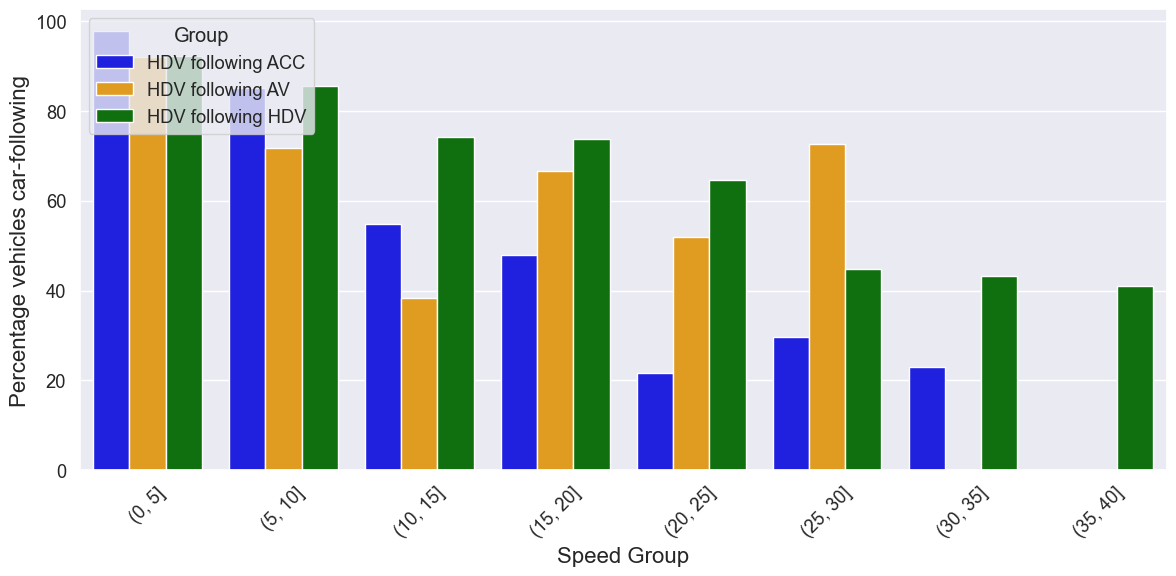

145739
141050


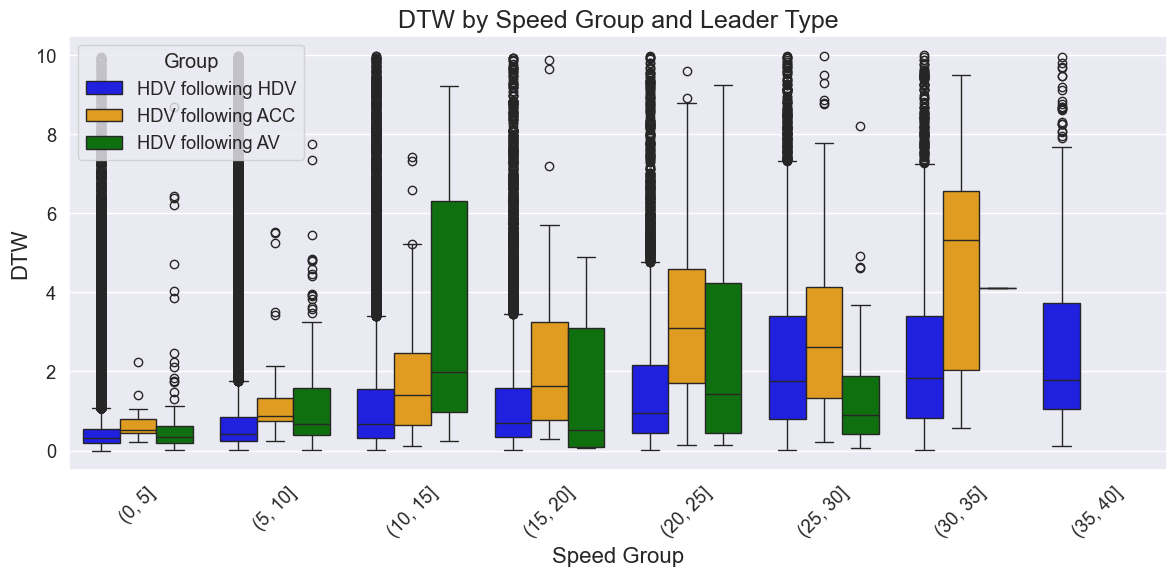

2891.4
1980.4
720033.5


In [2]:
# we compare the impact of following an ADAS on the car-following behaviour

path_list = ['294_L1_by_run/','294_L2_by_run/','90_94_static_by_run/','90_94_moving_by_run/']
glob_dtw = 'out/data/DTW/'
glob_trajs = 'data/by_run/'

df_DTW = car_follow.merge_df_dtw(path_list,glob_dtw,glob_trajs)
df_DTW.to_csv('out/data/DTW/summary.csv',index=False)
results = car_follow.plot_CF_DTW(df_DTW)
results.to_csv('out/data/DTW/percentage_cf.csv')
car_follow.plot_speed_DTW(df_DTW)
teststats = car_follow.compare_groups_statistics(df_DTW)
ACC = df_DTW[(df_DTW['leader is ACC']==True)&(df_DTW['location']=='294_L1_by_run/')]
AV = df_DTW[(df_DTW['leader is ACC']==True)&(df_DTW['location']!='294_L1_by_run/')]
HDV = df_DTW[(df_DTW['leader is ACC']==False)]
result = ACC.groupby('id')['time'].agg(lambda x: x.max() - x.min()).reset_index()
result.rename(columns={'time': 'time_range'}, inplace=True)
print(result['time_range'].sum())
result = AV.groupby('id')['time'].agg(lambda x: x.max() - x.min()).reset_index()
result.rename(columns={'time': 'time_range'}, inplace=True)
print(result['time_range'].sum())
result = HDV.groupby('id')['time'].agg(lambda x: x.max() - x.min()).reset_index()
result.rename(columns={'time': 'time_range'}, inplace=True)
print(result['time_range'].sum())


all merged for 294_L1_by_run/
all merged for 294_L2_by_run/
all merged for 90_94_static_by_run/
all merged for 90_94_moving_by_run/


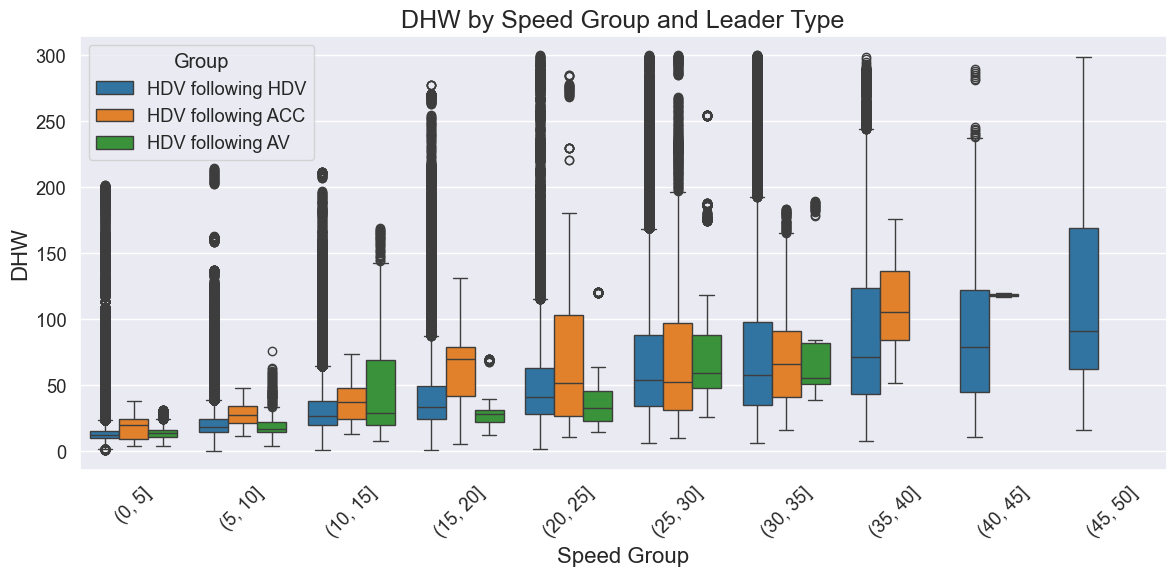

In [4]:
# we compare the impact of following an ADAS on the car-following execution

path_list = ['294_L1_by_run/','294_L2_by_run/','90_94_static_by_run/','90_94_moving_by_run/']
glob_trajs = 'data/by_run/'

trajs =  cf_exe.merge_df_trajs(path_list,glob_trajs)
results_df = cf_exe.compare_groups_statistics(trajs)
results_df.to_csv('out/data/tests/DHW_ranges_tests.csv')


trajs.replace([np.inf, -np.inf], np.nan, inplace=True)
cf_exe.plot_speed_DHW(trajs)


all merged for 294_L1_by_run/
all merged for 90_94_static_by_run/
all merged for 90_94_moving_by_run/


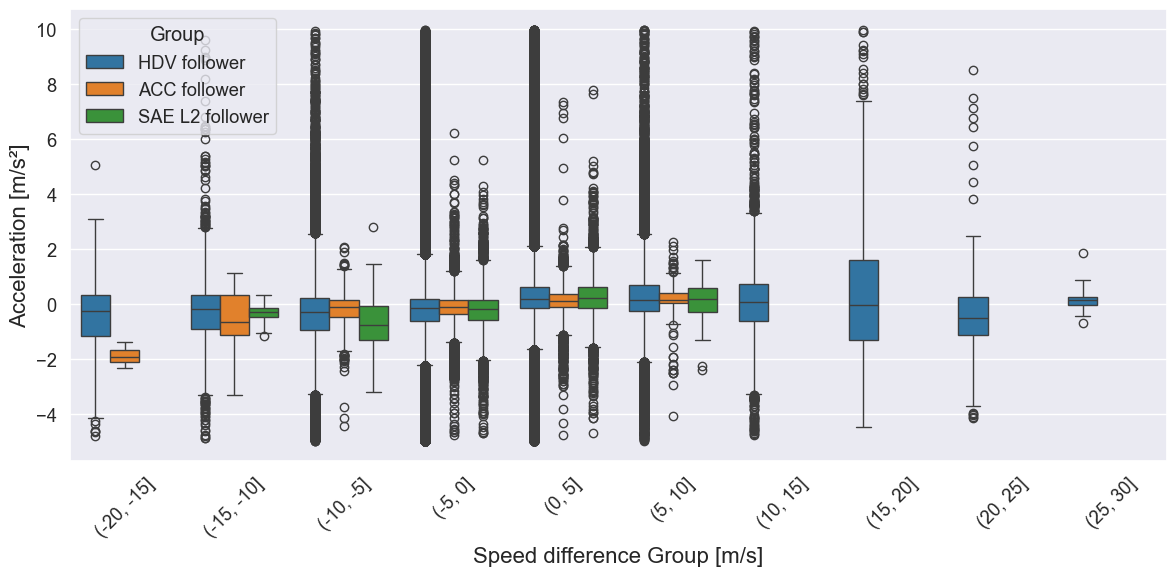

In [6]:
# we compare the impact of following an ADAS on the response to a stimulus

path_list = ['294_L1_by_run/','90_94_static_by_run/','90_94_moving_by_run/']
glob_trajs = 'data/by_run/'

merged = stim_compa.merge_df_trajs(path_list,glob_trajs)
merged.reset_index(inplace = True, drop = True)
results_df = stim_compa.test_acceleration_differences(merged)
results_df.to_csv('out/data/tests/speedelta_test.csv')

stim_compa.plot_response_vs_stimulus(merged)

## Examining the impact of following an ADAS on traffic safety

all merged for 294_L1_by_run/
all merged for 90_94_static_by_run/
all merged for 90_94_moving_by_run/
48 869
17452 769456
Congested TTC 0.11912447101913554 3.6396638758838313e-11 869
Congested TTC ACC v AV 0.13914044128683645 2.180225381852622e-10 1817
Congested TTC AV 0.0942598051251351 2.042817067344909e-14 291751
Free flow TTC 0.18486518051316003 9.853271526968711e-25 866
0.04602991944764097
0.017083060555062365


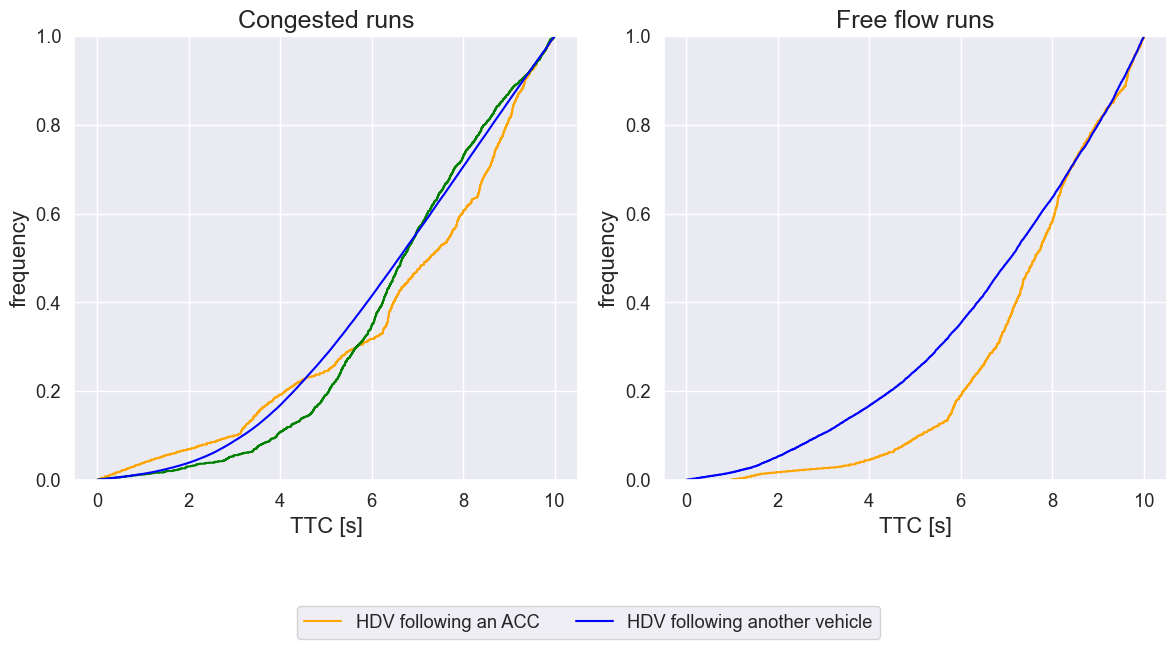

In [8]:

path_list = ['294_L1_by_run/','90_94_static_by_run/','90_94_moving_by_run/']
glob_trajs = 'data/by_run/'

merged = safety_compa.merge_df_trajs(path_list,glob_trajs)
safety_compa.test_impact_follow_ACC(merged,22,'TTC')

## Examining the impact of following an ADAS on lane changing probability

the following cell can be bypassed, the intermediate result is already saved in the reposit

⚠️

In [ ]:
#prepare data for the logit model

logit_df = pd.DataFrame()
path_list = ['294_L1_by_run/','294_L2_by_run/','90_94_static_by_run/','90_94_moving_by_run/']
glob_dtw = 'out/data/DTW/'
glob_trajs = 'data/by_run/'
for p in path_list:
    for f in os.listdir(glob_dtw+p):
        trajs = pd.read_csv(glob_trajs+p+f)
        dtw = pd.read_csv(glob_dtw+p+f)
        trajs = LC_preprocessing.compute_speed_diff(trajs)
        loc_logit = LC_preprocessing.construct_Logit_DF(trajs,dtw)
        loc_logit['location'] = [p for k in range(len(loc_logit['id']))]
        logit_df = pd.concat([logit_df,loc_logit])
logit_df.to_csv('out/data/LC_data/logit_df.csv')

In [11]:
#model lane change
path = 'out/data/LC/logit_df.csv'
data_LC = Logit_LC.prepare_data(path)

logit_results = Logit_LC.logit_model(data_LC)

display(logit_results)

In [ ]:
display(logit_results.getEstimatedParameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
beta_DHW,-0.003553,0.000633,-5.611949,2.000608e-08
beta_DTW,0.002122,0.000346,6.128554,8.868126e-10
beta_constant_left,-2.093400,0.037310,-56.107708,0.000000e+00
beta_constant_right,-7.725238,0.334987,-23.061294,0.000000e+00
beta_leader_L1_left,1.640410,0.229903,7.135226,9.663381e-13
beta_leader_L1_right,-0.122780,0.362157,-0.339026,7.345903e-01
beta_leader_L2_left,0.148416,0.388314,0.382205,7.023094e-01
beta_leader_L2_right,-0.312565,0.366413,-0.853041,3.936367e-01
beta_mean_speed_delta,2.282204,0.312972,7.292032,3.053113e-13


In [30]:
df = logit_results.getEstimatedParameters()
df.insert(0, "parameter", df.index)
df.reset_index(drop=True, inplace=True)
df["Sigma"] = df["Value"] / df["Rob. Std err"]
df

,parameter,Value,Rob. Std err,Rob. t-test,Rob. p-value,Sigma
0,beta_DHW,-0.003553,0.000633,-5.611949,2.000608e-08,-5.611949
1,beta_DTW,0.002122,0.000346,6.128554,8.868126e-10,6.128554
2,beta_constant_left,-2.093400,0.037310,-56.107708,0.000000e+00,-56.107708
3,beta_constant_right,-7.725238,0.334987,-23.061294,0.000000e+00,-23.061294
4,beta_leader_L1_left,1.640410,0.229903,7.135226,9.663381e-13,7.135226
5,beta_leader_L1_right,-0.122780,0.362157,-0.339026,7.345903e-01,-0.339026
6,beta_leader_L2_left,0.148416,0.388314,0.382205,7.023094e-01,0.382205
7,beta_leader_L2_right,-0.312565,0.366413,-0.853041,3.936367e-01,-0.853041
8,beta_mean_speed_delta,2.282204,0.312972,7.292032,3.053113e-13,7.292032


compare if the obtained betas are different across L1 and L2

In [34]:
from scipy.stats import chi2

# Extract the coefficients and their standard errors
coefficients = df["Value"].values
std_errors = df["Rob. Std err"].values

# Create the covariance matrix (assuming it's diagonal for simplicity)
cov_matrix = np.diag(std_errors**2)

# Define the contrast matrix R for the hypothesis tests
# For L1_left vs L2_left
R_left = np.zeros((1, len(coefficients)))
R_left[0, df["parameter"].tolist().index("beta_leader_L1_left")] = 1
R_left[0, df["parameter"].tolist().index("beta_leader_L2_left")] = -1

# For L1_right vs L2_right
R_right = np.zeros((1, len(coefficients)))
R_right[0, df["parameter"].tolist().index("beta_leader_L1_right")] = 1
R_right[0, df["parameter"].tolist().index("beta_leader_L2_right")] = -1

# Perform Wald test for L1_left vs L2_left
Rb_left = R_left @ coefficients
var_Rb_left = R_left @ cov_matrix @ R_left.T
W_left = Rb_left.T @ np.linalg.inv(var_Rb_left) @ Rb_left
p_value_left = chi2.sf(W_left, df=1)

# Perform Wald test for L1_right vs L2_right
Rb_right = R_right @ coefficients
var_Rb_right = R_right @ cov_matrix @ R_right.T
W_right = Rb_right.T @ np.linalg.inv(var_Rb_right) @ Rb_right
p_value_right = chi2.sf(W_right, df=1)

W_left, p_value_left, W_right, p_value_right

(np.float64(10.931117275254747),
 np.float64(0.0009456245193523359),
 np.float64(0.1357049158808173),
 np.float64(0.7125888037634478))